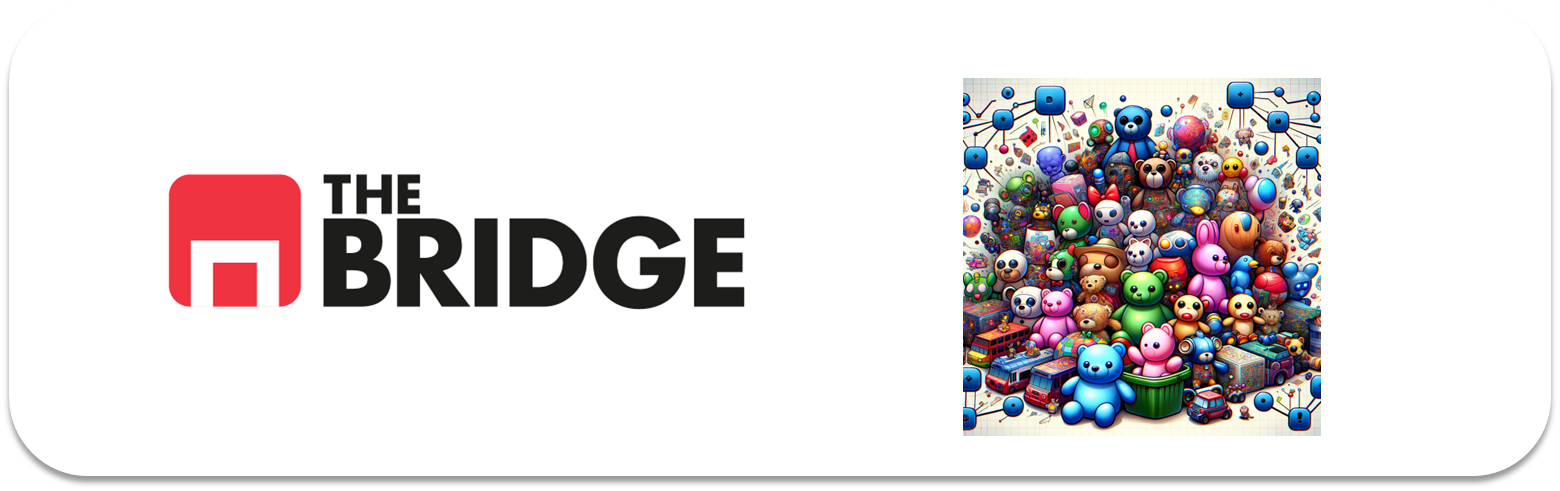

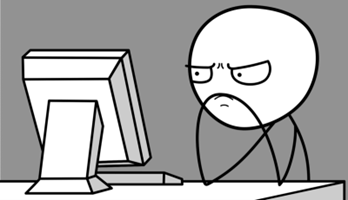

## PRÁCTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import DBSCAN, AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import KNeighborsClassifier

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ellos se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


##### 1. Entender el problema

Objetivo: bebidas de diferentes sabores (preferencias del usuario) con propiedades antifatiga y antisueño (clave).  
Quieren un clasificador pero no tienen target, además ellos interpretan segmentaciones resultantes (no labels) -- > Problema de clasificación no supervisado.  

Algoritmos a usar y comparar:
* DBSCAN: porque lo pide el ejercicio
* Clustering jerárquico aglomerativo: porque quieren poder establecer relaciones entre las segmentaciones (similitud)

Dicen que no esperan menos de 3 ni mas de 5 segmentos, con lo que ya tenemos los posibles valores de k para el modelo jerárquico y una orientación de min_samples para el DBSCAN

##### 2. Cargar datos, visualizar

In [2]:
df = pd.read_csv('./data/empowering_drinks.csv', sep = '|')
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


* No se observan nulos, todas las features son numéricas.  
* Dataset pequeño, se podría usar en algoritmo jerárquico directamente sin que su lentitud fuera problemática

In [4]:
# Renombro columnas por comodidad

df.columns = ['azucares', 'vit_B', 'cafeina', 'ac_citrico', 'taurina']
df.head()

,azucares,vit_B,cafeina,ac_citrico,taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


##### 3. MiniEDA: Selección de features

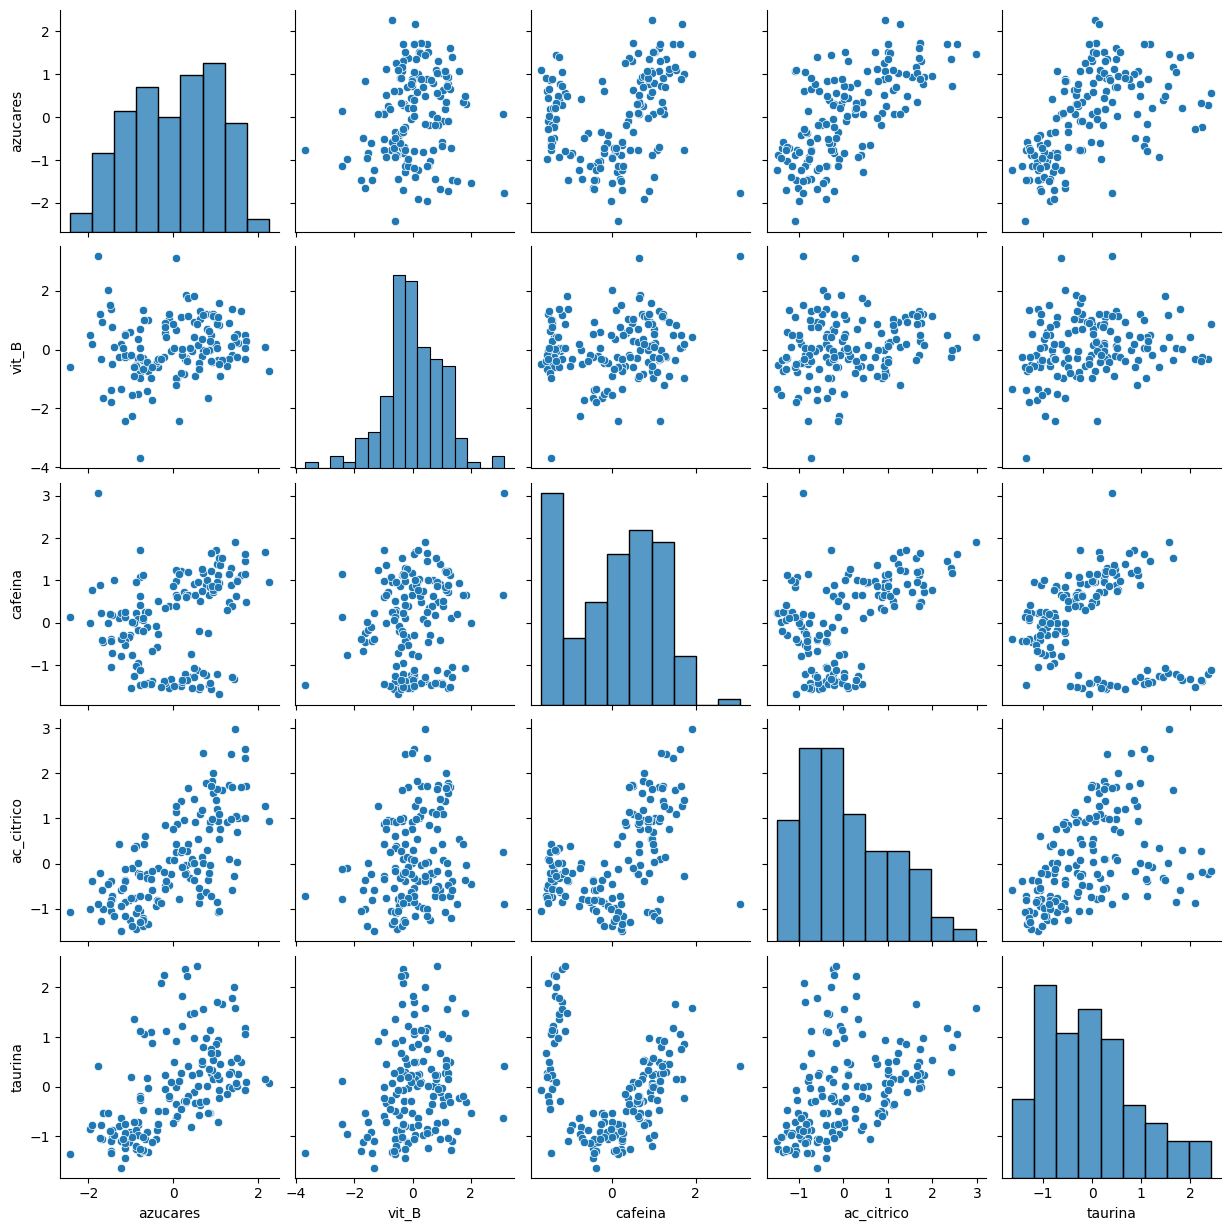

In [5]:
sns.pairplot(df);

No se observan formas radiales (KMeans no saldría bien), pero sí parece que se observan zonas de mayor y menor densidad entre traurina-cafeína y taurina-ácido cítrico (DBSCAN iría mejor).  

Como no se ve bien, hay que mirar cada combinación de features individualmente.

azucares vs vit_B


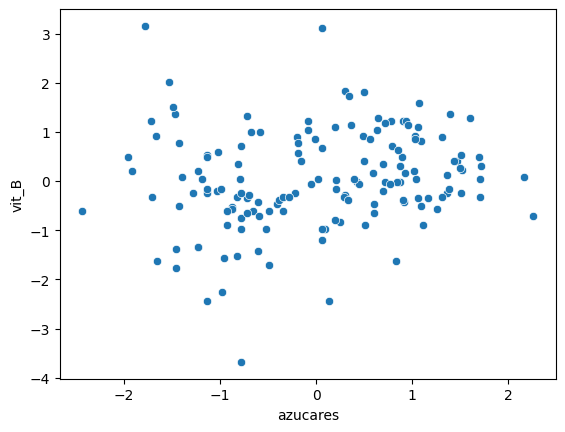

azucares vs cafeina


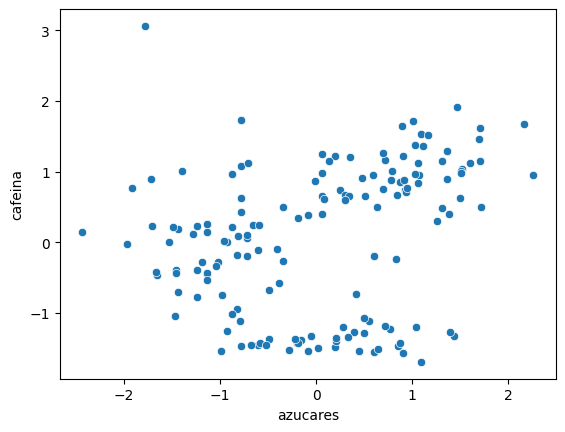

azucares vs ac_citrico


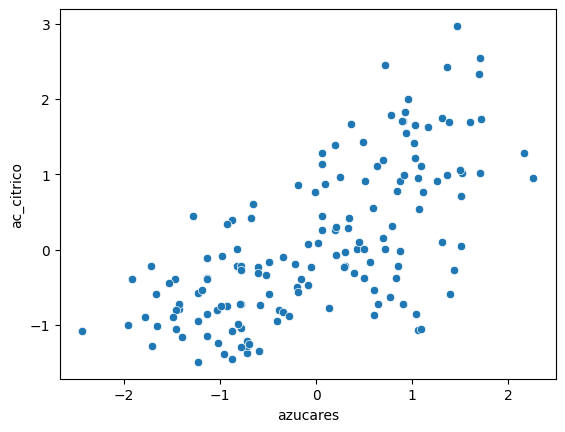

azucares vs taurina


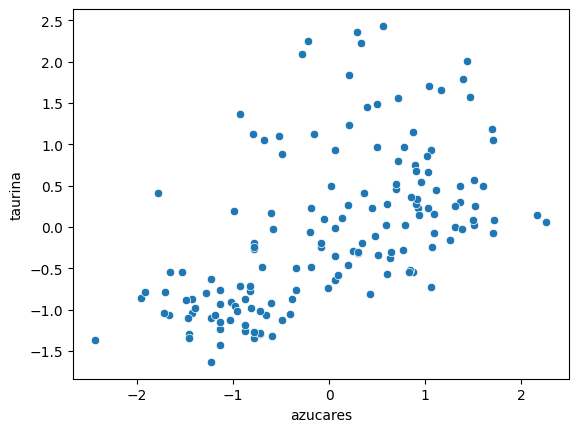

vit_B vs cafeina


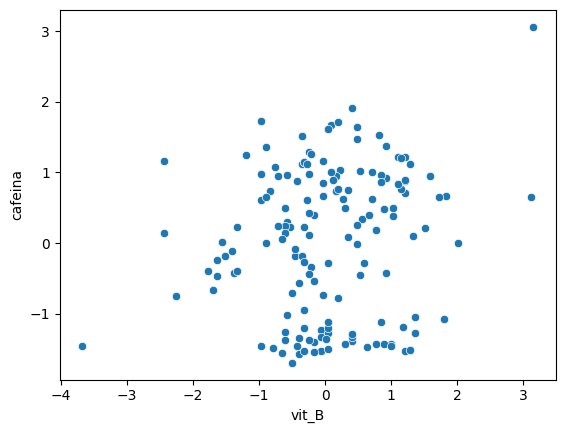

vit_B vs ac_citrico


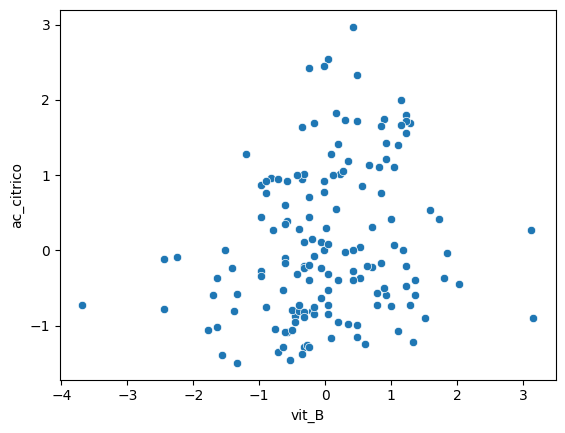

vit_B vs taurina


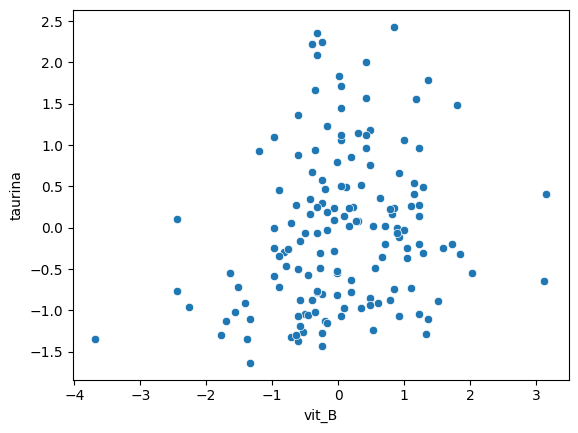

cafeina vs ac_citrico


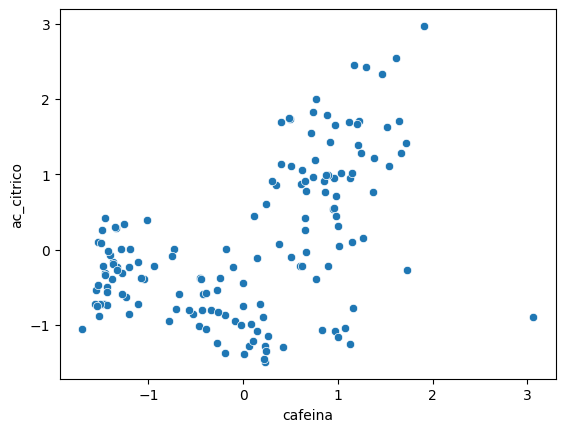

cafeina vs taurina


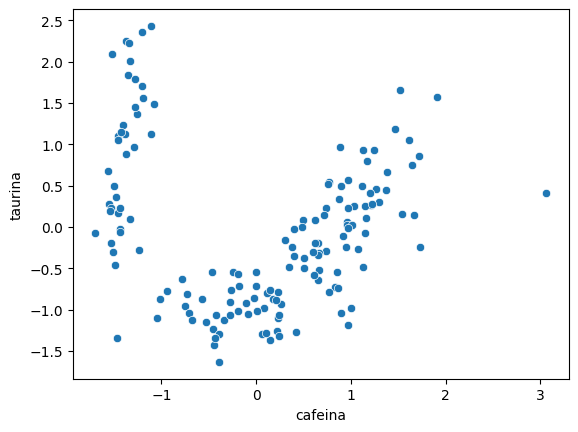

ac_citrico vs taurina


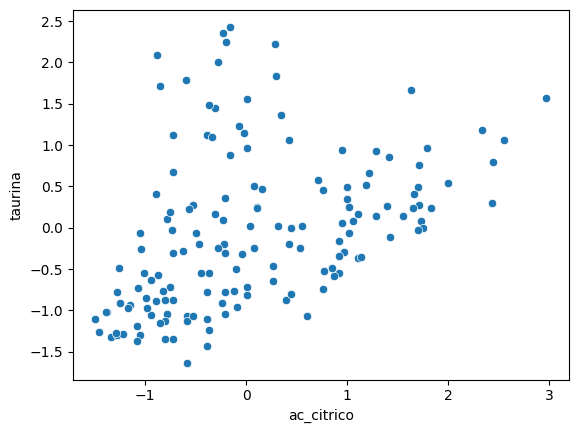

In [6]:
pairs = [
    ('azucares', 'vit_B'),
    ('azucares', 'cafeina'),
    ('azucares', 'ac_citrico'),
    ('azucares', 'taurina'),
    ('vit_B', 'cafeina'),
    ('vit_B', 'ac_citrico'),
    ('vit_B', 'taurina'),
    ('cafeina', 'ac_citrico'),
    ('cafeina', 'taurina'),
    ('ac_citrico', 'taurina')
]

for e in pairs:
    print(f'{e[0]} vs {e[1]}')
    sns.scatterplot(df, x = e[0], y = e[1])
    plt.show()

Sigue sin verse nada muy claro, las agrupaciones más significativas serían:
* azucares-cafeina: posible línea horizontal en la parte inferior y otra cercana a la diagonal, pero no está nada clara.
* ac_citrico-cafeina: posible agrupación en esquina inferior izda y línea ascendente desde los valores centrales de la cafeina, pero no está claro.
* taurina-cafeina: la más clara, dos zonas de alta densidad separadas por una zona vacía.
* taurina-ac_citrico: forma parecida a una V, pero muy poco definida.

La única realmente clara es la de taurina-cafeina. Si tuviera que seleccionar features solo me quedaría con esas dos, pero como en otras también parece intuirse algo voy ha hacer pruebas con solo taurina-cafeina y con todas para comparar.

In [7]:
# Feature selection

features_clear = ['cafeina', 'taurina']
features_all = df.columns.to_list()

##### 4. Tratamiento de Features

In [8]:
df.describe()

,azucares,vit_B,cafeina,ac_citrico,taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


* ¿Tiene sentido que los ingredientes tengan valores negativos? Interpreto que sí porque hacen referencia a la versión ya comercializada, pero si fuera un caso real pediría confirmación a negocio para entender bien de dónde parten y en qué consisten las modificaciones que quieren.

Todas las variables son numéricas, pero viendo que tienen rangos casi iguales y que la media está en torno al 0 y la desviación estándar al 1, no voy a tocar nada (parece que ya está aplicado un StandardScaler())

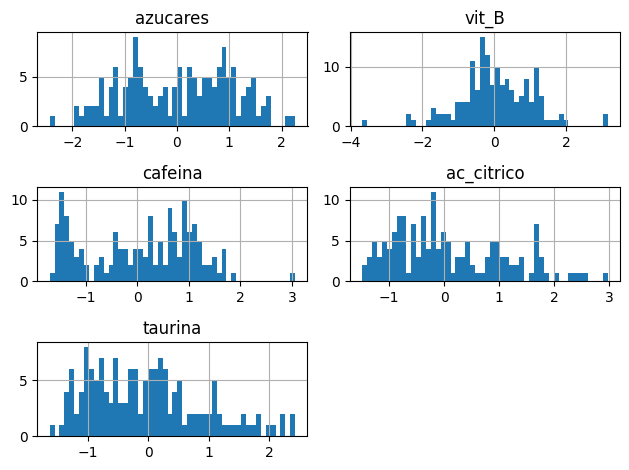

In [9]:
df.hist(bins = 50);
plt.tight_layout()

Las distribuciones no son especialmente irregulares ni hay outliers muy separados, no vamos a tocar nada. Si salen los modelos mal, se revisarán y transformarán las features.

##### 5. Selección de modelos, selección de hiperparámetros

**DBSCAN**

Recordar que nos habían dicho que esperan entre 3 y 5 segmentaciones y que hay 153 puntos.  

Empezamos con todas las features

In [33]:
outlier_percent = []

for eps in np.linspace(0.001, 5, 50):
    dbscan = DBSCAN(eps = eps, min_samples = 2 * df.shape[1])
    dbscan.fit(df)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    outlier_percent.append(perc_outliers)

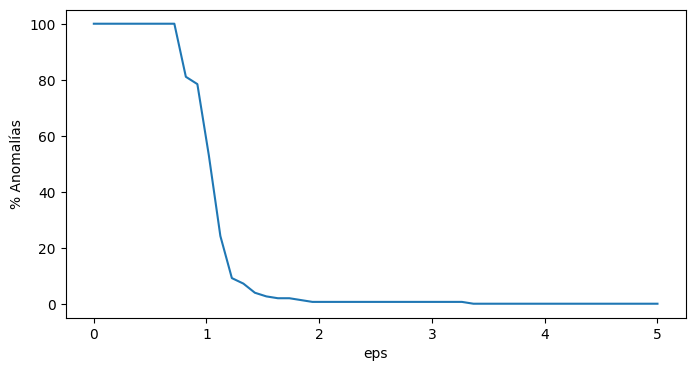

In [37]:
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x = np.linspace(0.001, 5, 50),y = outlier_percent)
plt.ylabel('% Anomalías')
plt.xlabel('eps')
plt.show()

##### 6. Entrenamiento, visualización de resultados

##### 7. Discusión de los mismos

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.